# Microsegregation during solidification of Ni-Cu alloy

Here, we study the segregation effects in the solidification of Ni-Cu alloy of 10% Cu atomic fraction.

First, let's import the necessary libraries and the Ni-Cu phase diagram (calculated before)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.special import erf, erfc

% matplotlib inline

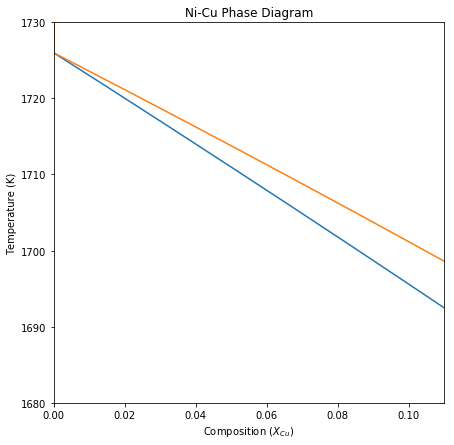

In [2]:
# import the phase diagram
phase_diag = np.genfromtxt('Ni-Cu-PhaseDiagram.csv',delimiter=',')


# plot the phase diagram
fig, ax = plt.subplots(figsize = (7,7))

ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Composition ($X_{Cu}$)')
ax.set_xlim(0,0.11)
ax.set_ylim(1680,1730)
ax.set_title('Ni-Cu Phase Diagram')
ax.plot(phase_diag[:,1],phase_diag[:,0], label='Solidus')
ax.plot(phase_diag[:,2],phase_diag[:,0], label='Liquidus')

# Our composition of interest

C_0 = 0.1

## Calculation of some parameters

We have to calculate some essential parameters using our previous analyses - namely, the partition coefficient and the slope of the liquidus at the considered composition.

We also need the value of $\zeta_f^s$ from the semi-infinite solidification problem. And the diffusivity of copper in nickel.

Now, let's calculate the partition coefficient $\kappa = \frac{C_s}{C_l}$ and melting temperature at $C_l = 0.1$, and the slope of the liquidus 'm'

In [3]:
# Let's find the values by interpolation

C_s = np.interp(C_0,np.flip(phase_diag[:,2],0),np.flip(phase_diag[:,1],0))
T_m = np.interp(C_0,np.flip(phase_diag[:,2],0),np.flip(phase_diag[:,0],0))

print("@C_l = " +str(C_0) + ", C_s = " + str(np.round(C_s,3)) + ", T = " + str(np.round(T_m,3)))

# partition coefficient

k = C_s/0.1
print("\nPartion coefficient = " + str(np.round(k,4)))

# slope calculation

liquidus_slopes = np.gradient(phase_diag[:,0],phase_diag[:,2])
m = np.interp(0.1,np.flip(phase_diag[:,2],0),np.flip(liquidus_slopes,0))

print("\nLiquidus Slope = "+str(m))

@C_l = 0.1, C_s = 0.082, T = 1701.172

Partion coefficient = 0.82

Liquidus Slope = -256.1672755763569


Now, we'll calculate $\zeta_f^s$ and the diffusivity

In [4]:
# Define some parameters for Nickel

rho = 8900       # density            Kg/m^3
L_f = 297000     # Heat of fusion     J/Kg
C_p = 502        # Specific heat      J/(Kg.K)

k_s = 106        # Conductivity of solid    W/(m.K) (value at 527 C)
k_l = 55         # Conductivity of liquid   W/(m.K) (value at 665 C)

a_s = k_s/(rho*C_p)  # Thermal diffusivity of solid
a_l = k_l/(rho*C_p)  # Thermal diffusivity of liquid

In [5]:
def zeta_function(zeta, T_w, T_inf):
    
    a = rho*zeta*np.sqrt(a_s)*L_f
    b = (k_l/np.sqrt(a_l))*(T_m - T_inf)/(np.sqrt(np.pi)*erfc(zeta*np.sqrt(a_s/a_l)))*np.exp(-np.power(zeta,2)*a_s/a_l)
    c = (k_s/np.sqrt(a_s))*(T_m - T_w)/(np.sqrt(np.pi)*erf(zeta))*np.exp(-np.power(zeta,2))
    
    return a+b-c

# Wall temp = 1300, T_inf = 1300

zeta_fs = opt.fsolve(zeta_function, C_0, args=(1300,1300))
zeta_fs = zeta_fs[0]
print(zeta_fs)

0.3731180249515396


In [6]:
D = 0.724*np.exp(-61000/(8.314*T_m))*0.0001  # m^2/s
print(D)

9.697522541810338e-07


## Plotting variations with fraction solidified

Now, let's plot the variations of liquid composition($C_l$), Temperature at interface($T$) and Average solid composition($<C_s>$) with fraction solidified($f_s$) - using some models. 


For the Clyne-Kurz model, we must calculate a parameter $\zeta$ given by

### Calculation of $\zeta$

$$\zeta = \frac{D_s}{4 \alpha_s \lambda^2} (1-e^{\frac{-4 \alpha_s \lambda^2}{D_s}}) - \frac{1}{2}e^{\frac{-2 \alpha_s \lambda^2}{D_s}}$$

where $\lambda = \zeta_f^s$

In [7]:
zeta = D/(4*a_s*np.power(zeta_fs,2)) * (1-np.exp(-4*a_s*np.power(zeta_fs,2)/D)) - np.exp(-2*a_s*np.power(zeta_fs,2)/D)/2

print(zeta)

0.07284968355538232


In [8]:
a_s

2.3725323425399527e-05

### Plotting profiles

#### Clyne-Kurz model:

$$C_l = C_0(1-f_s(1-2\zeta k))^{\frac{k-1}{1-2\zeta k}}$$

#### Brody-Femings model:

$$C_l = C_0(1-f_s(1-\frac{kD_s}{2 \alpha \lambda^2}))^{\frac{1-k}{1-\frac{kD_s}{2 \alpha \lambda^2}}}$$

#### Schiel model:

$$C_l = C_0(1-f_s)^{k-1}$$

#### Equilibrium model:

$$C_l = \frac{C_0}{1+(k-1)f_s}$$

#### Other values
$$<C_s> = \frac{C_0 - C_l(1-f_s)}{f_s}$$

$$T = T_m + mC_l$$

/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


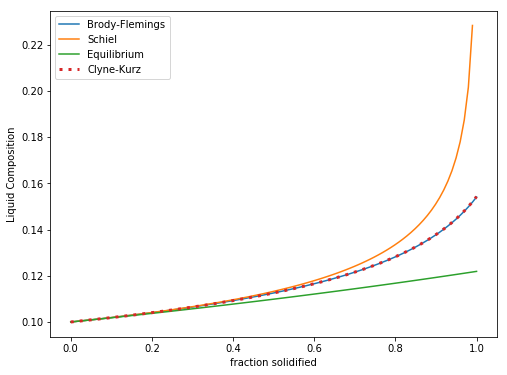

In [9]:
# Composition of liquid

# Clyne-Kurz

def C_l_ck(f_s):
    
    return C_0*np.power((1-f_s*(1-2*zeta*k)),(k-1)/(1-2*zeta*k))

# Brody-Flemings

def C_l_bf(f_s):
    
    return C_0*np.power((1-f_s*(1-k*D/(2*a_s*np.power(zeta_fs,2)))),(k-1)/(1-k*D/(2*a_s*np.power(zeta_fs,2))))

# Schiel

def C_l_sh(f_s):
    
    return C_0*np.power(1-f_s,k-1)

# Equilibrium

def C_l_eq(f_s):
    
    return C_0/(1+(k-1)*f_s)

# Onto plotting

f_ses = np.linspace(0,1,100)

fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel("fraction solidified")
ax.set_ylabel("Liquid Composition")

ax.plot(f_ses,C_l_bf(f_ses),label='Brody-Flemings')
ax.plot(f_ses,C_l_sh(f_ses),label='Schiel')
ax.plot(f_ses,C_l_eq(f_ses),label='Equilibrium')
ax.plot(f_ses,C_l_ck(f_ses),label='Clyne-Kurz',linestyle=(0,(1,2)), linewidth=3)

ax.legend()

We see that the Clyne-Kurz model gives very similar results to the Brody-Flemings model. In the Clyne-Kurz model, $\zeta \in (0,\frac{1}{2})$.

As $$\zeta \rightarrow \frac{1}{2} \implies \frac{D_s}{2 \alpha \lambda^2} \rightarrow 1$$

Clyne-Kurz model approaches the equilibrium model, as seen below

/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


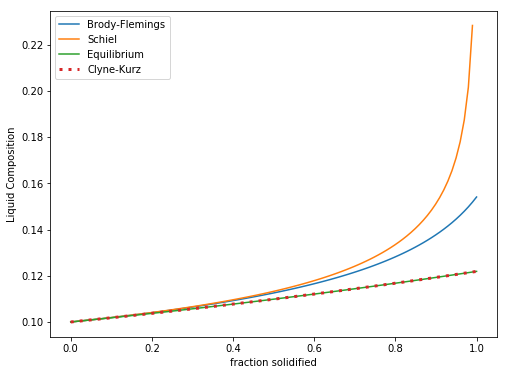

In [10]:
# Zeta approaches 1/2

zeta = 1/2

f_ses = np.linspace(0,1,100)

fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel("fraction solidified")
ax.set_ylabel("Liquid Composition")

ax.plot(f_ses,C_l_bf(f_ses),label='Brody-Flemings')
ax.plot(f_ses,C_l_sh(f_ses),label='Schiel')
ax.plot(f_ses,C_l_eq(f_ses),label='Equilibrium')
ax.plot(f_ses,C_l_ck(f_ses),label='Clyne-Kurz',linestyle=(0,(1,2)), linewidth=3)

ax.legend()

As $$\zeta \rightarrow 0 \implies \frac{D_s}{2 \alpha \lambda^2} \rightarrow 0$$

Clyne-Kurz model approaches the Schiel model, as seen below

/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys


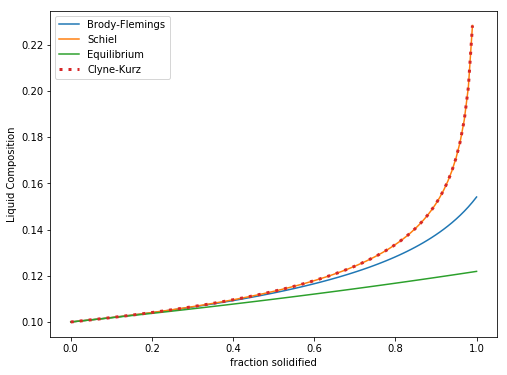

In [11]:
zeta = 0

f_ses = np.linspace(0,1,100)

fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel("fraction solidified")
ax.set_ylabel("Liquid Composition")

ax.plot(f_ses,C_l_bf(f_ses),label='Brody-Flemings')
ax.plot(f_ses,C_l_sh(f_ses),label='Schiel')
ax.plot(f_ses,C_l_eq(f_ses),label='Equilibrium')
ax.plot(f_ses,C_l_ck(f_ses),label='Clyne-Kurz',linestyle=(0,(1,2)), linewidth=3)

ax.legend()

### Interface temperature and Avg. solid composition

Now, for the other plots - $<C_s>$ and $T$

In [12]:
zeta = D/(4*a_s*np.power(zeta_fs,2)) * (1-np.exp(-4*a_s*np.power(zeta_fs,2)/D)) - np.exp(-2*a_s*np.power(zeta_fs,2)/D)/2
print(zeta)

0.07284968355538232


/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


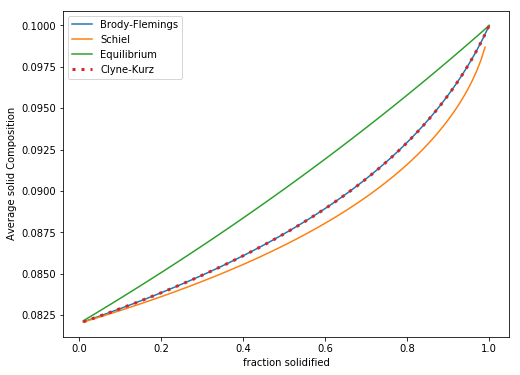

In [13]:
def avg_cs(f_s,C_l):
    
    return (C_0 - C_l(f_s)*(1-f_s))/f_s

fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel("fraction solidified")
ax.set_ylabel("Average solid Composition")

ax.plot(f_ses,avg_cs(f_ses,C_l_bf),label='Brody-Flemings')
ax.plot(f_ses,avg_cs(f_ses,C_l_sh),label='Schiel')
ax.plot(f_ses,avg_cs(f_ses,C_l_eq),label='Equilibrium')
ax.plot(f_ses,avg_cs(f_ses,C_l_ck),label='Clyne-Kurz',linestyle=(0,(1,2)), linewidth=3)

ax.legend()

/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power


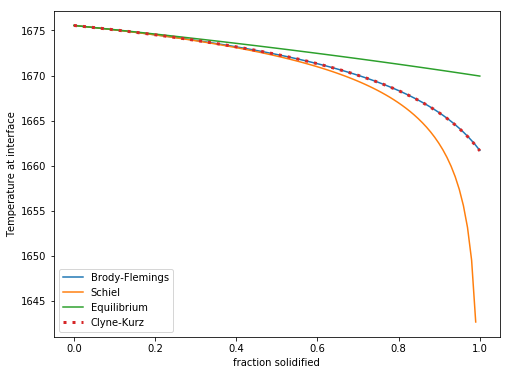

In [14]:
def T(f_s,C_l):
    
    return T_m + m*C_l(f_s)

fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel("fraction solidified")
ax.set_ylabel("Temperature at interface")

ax.plot(f_ses,T(f_ses,C_l_bf),label='Brody-Flemings')
ax.plot(f_ses,T(f_ses,C_l_sh),label='Schiel')
ax.plot(f_ses,T(f_ses,C_l_eq),label='Equilibrium')
ax.plot(f_ses,T(f_ses,C_l_ck),label='Clyne-Kurz',linestyle=(0,(1,2)), linewidth=3)

ax.legend()